In [1]:
!pip install rectools optuna shap catboost > None

In [2]:
import os
import datetime

import pandas as pd
import numpy as np
from scipy import stats
from scipy.sparse import csr_matrix

import requests
from tqdm.auto import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from rectools.metrics import MAP, calc_metrics, Recall, NDCG
from rectools.models import ImplicitALSWrapperModel, LightFMWrapperModel
from rectools.models.popular import PopularModel
from rectools import Columns
from rectools.dataset import Dataset

from lightfm import LightFM
from lightfm.data import Dataset as LFMDataset

from implicit.als import AlternatingLeastSquares
from implicit.bpr import BayesianPersonalizedRanking
from implicit.lmf import LogisticMatrixFactorization

from lightgbm import LGBMRanker
from xgboost import XGBRanker
from catboost import CatBoostRanker, Pool

import optuna

import dill

from typing import Callable, Dict, Set, List, Optional, Any, Tuple
import gc
from timeit import Timer

import shap

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
%cd gdrive/MyDrive/recsys/

/content/gdrive/MyDrive/recsys


In [6]:
os.environ["OPENBLAS_NUM_THREADS"] = "0"

In [7]:
SEED = 2022
K_RECOS = 10

## Utils

In [8]:
def avg_user_metric(
        y_true: np.ndarray,
        y_pred: np.ndarray,
        user_ids: np.ndarray,
        metric_function: Callable[[np.ndarray, np.ndarray], float],
) -> float:
    """
    Вычисляем метрику, усредненную по всем значимым (есть разные таргеты) группам.
    :param y_true: список таргетов
    :param y_pred: список предсказаний
    :param user_ids: список групп (обычно это список user_id той же размерности, что и предсказания и таргеты)
    :param metric_function: усредняемая метрика(y_true, y_pred) -> float
    :return: значение метрики metric_function, усредненное по всем значимым группам
    """
    avg_score: float = 0.

    if len(y_pred) == len(y_true) == len(user_ids):
        l_ind: int = 0
        cur_group_id: int = user_ids[0] if len(user_ids) else 0
        n_groups: int = 0
        for r_ind, group_id in enumerate(user_ids):
            if group_id != cur_group_id or r_ind == len(user_ids) - 1:
                if r_ind == len(user_ids) - 1:
                    r_ind += 1
                # Если группа не состоит из одного и того же таргета - добавляем ее
                group_true = y_true[l_ind: r_ind]
                if not np.all(group_true == group_true[0]):
                    avg_score += metric_function(group_true, y_pred[l_ind: r_ind])
                    n_groups += 1
                l_ind = r_ind
                cur_group_id = group_id
        avg_score /= max(1, n_groups)
    else:
        raise ValueError(f'Размерности не совпадают: '
                         f'y_pred - {len(y_pred)}, y_true - {len(y_true)}, user_ids - {len(user_ids)}')
    return avg_score

In [9]:
def calc_metrics_(candidates_df, rank_col: str) -> Dict[str, float]:
    metrics = {
        'map@10': MAP(k = 10),
        'recall@10': Recall(k = 10),
    }
    return calc_metrics(
        metrics=metrics,
        reco=(
            candidates_df
            .rename(columns={rank_col: Columns.Rank})
            [[Columns.User, Columns.Item, Columns.Rank]]
            [candidates_df[Columns.User].isin(test_users)]
        ),
        interactions=(
            ranker_data
            [[Columns.User, Columns.Item, Columns.Datetime, Columns.Weight]]
            [ranker_data[Columns.User].isin(test_users)]
        ), 
        prev_interactions=(
            base_models_data
            [[Columns.User, Columns.Item, Columns.Datetime, Columns.Weight]]
            [base_models_data[Columns.User].isin(test_users)]
        ),
        catalog=items['item_id'].unique()
    )

## Get data

In [10]:
interactions = pd.read_csv('kion_train/interactions.csv')
users = pd.read_csv('kion_train/users.csv')
items = pd.read_csv('kion_train/items.csv')

In [11]:
interactions.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0


### Interactions

In [12]:
interactions.rename(
    columns={
        'last_watch_dt': Columns.Datetime,
        'watched_pct': Columns.Weight,
    }, 
    inplace=True,
) 
interactions['datetime'] = interactions['datetime'].astype(np.datetime64)

interactions_default_values: Dict[str, Any] = {
   Columns.Datetime: interactions[Columns.Datetime].median(),
    Columns.Weight: 0.,
    'total_dur': 0,
}
interactions.fillna(interactions_default_values, inplace=True)
interactions.head()

,user_id,item_id,datetime,total_dur,weight
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0


### Users

In [14]:
def encode_cat_cols(df: pd.DataFrame, cat_cols) -> Tuple[pd.DataFrame, Dict]:
    cat_col_encoding = {} 

    for col in cat_cols:
        cat_col = df[col].astype('category').cat
        cat_col_encoding[col] = cat_col.categories
        df[col] = cat_col.codes.astype('category')
    return df, cat_col_encoding

users_cat_cols = [
     'age', 'income', 'sex', 'kids_flg'
]
users, users_cat_col_encoding = encode_cat_cols(users, users_cat_cols)
users.head()

,user_id,age,income,sex,kids_flg
0,973171,1,4,1,1
1,962099,0,2,1,0
2,1047345,3,3,0,0
3,721985,3,2,0,0
4,704055,2,4,0,0


### items

In [15]:
items_cat_cols = [
    'content_type', 'for_kids', 'studios',
]
items_text_cols = [
    'title', 'title_orig', 'genres', 'countries', 'directors', 'actors', 'description', 'keywords',
]
items_num_cols = [
    'release_year', 'age_rating', 
]
default_values_items = {
    'release_year': items['release_year'].median(),
    'age_rating': items['age_rating'].median(),
}

items, items_cat_col_encoding = encode_cat_cols(items, items_cat_cols) 
items = items.drop(items_text_cols, axis=1)
items.fillna(default_values_items, inplace=True)
items.head()

,item_id,content_type,release_year,for_kids,age_rating,studios
0,10711,0,2002.0,-1,16.0,-1
1,2508,0,2014.0,-1,16.0,-1
2,10716,0,2011.0,-1,16.0,-1
3,7868,0,2015.0,-1,16.0,-1
4,16268,0,1978.0,-1,12.0,33


## Train/test split

In [16]:
max_date = interactions[Columns.Datetime].max()
min_date = interactions[Columns.Datetime].min()

print(f'min дата в interactions: {min_date}')
print(f'max дата в interactions: {max_date}')
print(f'Продолжительность: {max_date - min_date}')

min дата в interactions: 2021-03-13 00:00:00
max дата в interactions: 2021-08-22 00:00:00
Продолжительность: 162 days 00:00:00


In [17]:
ranker_train_size = 0.7
ranker_val_size = 0.15
ranker_test_size = 0.15

In [18]:
ranker_days_count = 30
ranker_data = interactions[
    (interactions[Columns.Datetime] >= max_date - pd.Timedelta(days=ranker_days_count))
]

In [19]:
train_val_users, test_users = train_test_split(
    ranker_data['user_id'].unique(), random_state=SEED, test_size=ranker_test_size
)

train_users, val_users = train_test_split(
    train_val_users, random_state=SEED, test_size=ranker_val_size / (ranker_train_size + ranker_val_size)
)

In [20]:
base_models_data = interactions[
    (interactions[Columns.Datetime] < max_date - pd.Timedelta(days=ranker_days_count))
]

## Create ranker dataset

### From seminar code

In [21]:
# Получаем длину истории юзера 
base_models_data['user_hist'] = (
    base_models_data.groupby('user_id')
    ['item_id'].transform('count')
)
# Получаем популярность контента
base_models_data['item_pop'] = (
    base_models_data.groupby('item_id')
    ['user_id'].transform('count')
)
# Получаем среднюю популярность контента, просматриваемого этим юзером
base_models_data['user_avg_pop'] = (
    base_models_data.groupby('user_id')
    ['item_pop'].transform('mean')
)
# Получаем среднюю длину истории пользователя, которые смотрит этот контент
base_models_data['item_avg_hist'] = (
    base_models_data.groupby('item_id')
    ['user_hist'].transform('mean')
)
# Получаем популярность последнего просмотренного контента
base_models_data.sort_values(
    by=[Columns.User, Columns.Datetime], 
    ascending=[True, False], 
    ignore_index=True,
    inplace=True,
)
base_models_data['user_last_pop'] = (
    base_models_data.groupby('user_id')
    ['item_pop'].transform('first')
)
base_models_data.head(3)


,user_id,item_id,datetime,total_dur,weight,user_hist,item_pop,user_avg_pop,item_avg_hist,user_last_pop
0,0,6006,2021-07-20,1,0.0,6,5208,41885.0,16.891897,5208
1,0,7102,2021-07-19,169,3.0,6,11626,41885.0,20.349475,5208
2,0,14359,2021-07-19,130,2.0,6,6053,41885.0,22.546836,5208


### Custom features

In [22]:
# Users age mode for current item
full_base_data = base_models_data.merge(users, on='user_id', how='left')
full_base_data['age'] = full_base_data['age'].astype(float)
age_mode_data = full_base_data.groupby('item_id')['age'].agg(lambda x: stats.mode(x)[0][0]).reset_index().rename(columns={'age': 'user_age_mode'})
full_base_data = full_base_data.merge(age_mode_data, on='item_id', how='left')

# Users income mode for current item
full_base_data['income'] = full_base_data['income'].astype(float)
income_mode_data = full_base_data.groupby('item_id')['income'].agg(lambda x: stats.mode(x)[0][0]).reset_index().rename(columns={'income': 'user_income_mode'})
full_base_data = full_base_data.merge(income_mode_data, on='item_id', how='left')

# Item's popularity with kids
full_base_data['kids_flg_float'] = full_base_data['kids_flg'].astype(float)
full_base_data['kids_flg_float'] = full_base_data['kids_flg_float'].fillna(-1)
kids_pop_data = full_base_data[
    full_base_data['kids_flg_float'] != -1
].groupby('item_id')['kids_flg_float'].sum() / full_base_data[full_base_data['kids_flg_float'] != -1].groupby('item_id')['kids_flg_float'].count()
full_base_data = full_base_data.merge(kids_pop_data.reset_index().rename(columns={'kids_flg_float': 'kids_pop'}), on='item_id', how='left')

# Item's popularity with female/male
full_base_data['sex_float'] = full_base_data['sex'].astype(float)
full_base_data['sex_float'] = full_base_data['sex_float'].fillna(-1)
male_pop_data = full_base_data[
    full_base_data['sex_float'] != -1
].groupby('item_id')['sex_float'].sum() / full_base_data[full_base_data['sex_float'] != -1].groupby('item_id')['sex_float'].count()
full_base_data = full_base_data.merge(male_pop_data.reset_index().rename(columns={'sex_float': 'male_pop'}), on='item_id', how='left')

full_base_data['female_pop'] = 1 - full_base_data['male_pop']


full_base_data = full_base_data.drop(['kids_flg_float', 'sex_float', 'datetime'], axis=1)

In [23]:
assert full_base_data.shape[0] == base_models_data.shape[0]

In [24]:
del age_mode_data, income_mode_data, kids_pop_data, male_pop_data, interactions #base_models_data
gc.collect()

31

### Items/users features joining

In [25]:
for col in full_base_data.columns:
  if isinstance(full_base_data[col].dtype, pd.CategoricalDtype):
    if -1 not in full_base_data[col].cat.categories:
      full_base_data[col] = full_base_data[col].cat.add_categories(-1)
      full_base_data.fillna({col: -1}, inplace=True)
  else:
     full_base_data.fillna({col: -1}, inplace=True)

In [26]:
items = pd.merge(
    left=items, 
    right=(
        full_base_data
        [['item_id', 'item_pop', 'item_avg_hist', 'user_age_mode', 'user_income_mode', 'kids_pop', 'male_pop', 'female_pop']]
        .drop_duplicates()
    ),
    how='left',
    on='item_id',
)

users = pd.merge(
    left=users.drop(['age', 'income', 'kids_flg', 'sex'], axis=1), 
    right=(
        full_base_data
        [['user_id', 'user_hist', 'user_avg_pop', 'user_last_pop', 'age', 'income', 'kids_flg', 'sex']]
        .drop_duplicates()
    ),
    how='left',
    on='user_id',
)
users.head(3)

,user_id,user_hist,user_avg_pop,user_last_pop,age,income,kids_flg,sex
0,973171,5.0,19550.800000,93403.0,1.0,4.0,1,1
1,962099,13.0,1329.307692,260.0,0.0,2.0,0,1
2,1047345,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
items.head(3)

,item_id,content_type,release_year,for_kids,age_rating,studios,item_pop,item_avg_hist,user_age_mode,user_income_mode,kids_pop,male_pop,female_pop
0,10711,0,2002.0,-1,16.0,-1,4.0,63.250000,0.0,2.0,0.0,0.333333,0.666667
1,2508,0,2014.0,-1,16.0,-1,9.0,75.222222,-1.0,2.0,0.2,0.600000,0.400000
2,10716,0,2011.0,-1,16.0,-1,6.0,65.666667,0.0,3.0,0.4,0.400000,0.600000


#### Default features

In [28]:
for col in ['item_pop', 'item_avg_hist', 'male_pop', 'female_pop']:
  default_values_items[col] = full_base_data[col].median()

for col in ['content_type',  'kids_pop']:
  default_values_items[col] = 0

for col in ['for_kids', 'studios', 'user_income_mode', 'user_age_mode']:
  default_values_items[col] = -1
  
default_values_users = {
    'user_hist': 0,
    'user_avg_pop': full_base_data['user_avg_pop'].median(),
    'user_last_pop': full_base_data['user_last_pop'].median(),
}

### Build ranker dataset

In [29]:
def users_filter(
    user_list: np.ndarray,
    candidates_df: pd.DataFrame, 
    df: pd.DataFrame,
    how='right'
) -> pd.DataFrame:
    df = pd.merge(
        df[df['user_id'].isin(user_list)], 
        candidates_df[candidates_df['user_id'].isin(user_list)], 
        how=how,  # ? 
        on=['user_id', 'item_id']
    )
    
    default_values = {
        'als_score': df['als_score'].min() - 0.01,
        'als_rank': df['als_rank'].max() + 1,
        'lfm_score': df['lfm_score'].min() - 0.01,
        'lfm_rank': df['lfm_rank'].max() + 1,
        'pop_score': df['pop_score'].min() - 0.01,
        'pop_rank': df['pop_rank'].max() + 1,
        **interactions_default_values,
    }
    df.fillna(default_values, inplace=True)
        
    df.sort_values(
        by=['user_id', 'item_id'],
        inplace=True,
    )
    return df

In [30]:
def add_features(df: pd.DataFrame) -> pd.DataFrame:
    df = pd.merge(
        df, 
        users, 
        how='left', 
        on=['user_id']
    )
    df = pd.merge(
        df, 
        items, 
        how='left', 
        on=['item_id']
    )

    df.fillna(default_values_items, inplace=True)
    df.fillna(default_values_users, inplace=True)

    for col in df.columns:
        if isinstance(df[col].dtype, pd.CategoricalDtype):
            if -1 not in df[col].cat.categories:
                df[col] = df[col].cat.add_categories(-1)
            df.fillna({col: -1}, inplace=True)
    return df

In [31]:
candidates_df = pd.read_csv('als_candidates.csv').rename(
    columns={'rank': 'als_rank', 'score': 'als_score'}
).merge(
    pd.read_csv('lfm_candidates.csv').rename(
      columns={'rank': 'lfm_rank', 'score': 'lfm_score'}
    ),
    on=['user_id', 'item_id'],
     how='outer'
)
candidates_df = candidates_df[candidates_df['lfm_rank'] < 31]

top_popular = pd.read_csv('popular_candidates.csv').rename(columns={'rank': 'pop_rank', 'score': 'pop_score'}).drop('user_id', axis=1)
candidates_df = candidates_df.merge(top_popular, on='item_id', how='left')

candidates_df.head()

,Unnamed: 0,user_id,item_id,als_score,als_rank,lfm_score,lfm_rank,pop_score,pop_rank
0,37.0,699317,10876,1.353945,8.0,1.441382,30.0,1611.0,395
1,41.0,699317,3309,1.256813,12.0,2.057376,3.0,1393.0,470
2,42.0,699317,12132,1.244004,13.0,1.562747,25.0,2983.0,176
3,45.0,699317,16166,1.216029,16.0,1.915234,7.0,8522.0,41
4,58.0,699317,11654,1.118920,29.0,1.480057,29.0,3116.0,162


In [32]:
ranker_train = users_filter(train_users, candidates_df, ranker_data)
ranker_val = users_filter(val_users, candidates_df, ranker_data)
ranker_test = users_filter(test_users, candidates_df, ranker_data)

ranker_train.head()

,user_id,item_id,datetime,total_dur,weight,Unnamed: 0,als_score,als_rank,lfm_score,lfm_rank,pop_score,pop_rank
3700507,3,142,2021-08-13,5892.0,100.0,NaN,-0.010000,31.0,3.313618,7.0,35862.0,9
3700520,3,849,2021-07-01,0.0,0.0,NaN,-0.010000,31.0,2.616008,27.0,13304.0,27
1054911,3,1819,2021-07-01,0.0,0.0,16480250.0,0.146245,21.0,2.678070,25.0,9792.0,34
3700512,3,1844,2021-07-01,0.0,0.0,NaN,-0.010000,31.0,2.977912,15.0,22344.0,15
3700508,3,2657,2021-07-01,0.0,0.0,NaN,-0.010000,31.0,3.282620,9.0,55146.0,6


In [33]:
ranker_train = add_features(ranker_train)
ranker_val = add_features(ranker_val)
ranker_test = add_features(ranker_test)

ranker_train.head(3)

,user_id,item_id,datetime,total_dur,weight,Unnamed: 0,als_score,als_rank,lfm_score,lfm_rank,...,for_kids,age_rating,studios,item_pop,item_avg_hist,user_age_mode,user_income_mode,kids_pop,male_pop,female_pop
0,3,142,2021-08-13,5892.0,100.0,NaN,-0.010000,31.0,3.313618,7.0,...,-1,16.0,-1,35862.0,15.251464,2.0,2.0,0.366487,0.470470,0.529530
1,3,849,2021-07-01,0.0,0.0,NaN,-0.010000,31.0,2.616008,27.0,...,-1,18.0,-1,13304.0,16.444678,2.0,2.0,0.349387,0.655714,0.344286
2,3,1819,2021-07-01,0.0,0.0,16480250.0,0.146245,21.0,2.678070,25.0,...,-1,16.0,-1,9792.0,14.719669,1.0,2.0,0.349565,0.594162,0.405838


### Submission build

In [34]:
submission = pd.read_csv('sample_submission.csv').drop('item_id', axis=1)
submission_usrs = users_filter(submission['user_id'], candidates_df, ranker_data, how='outer')
submission.head(2)

,user_id
0,3
1,11


In [35]:
row_counts = submission_usrs.groupby('user_id').size().reset_index().rename(columns={0: 'size'})
less_recs_user = row_counts[row_counts['size'] < 10]['user_id']
less_recs_user.shape

(42831,)

In [36]:
cold_users = submission[~submission['user_id'].isin(submission_usrs['user_id'])]
cold_users = pd.concat([cold_users, pd.DataFrame(less_recs_user)])
cold_users.shape

(107774, 1)

In [37]:
top30_popular = pd.read_csv('top30_popular.csv').rename(columns={'score': 'pop_score', 'rank': 'pop_rank'})

In [38]:
cold_recs = [top30_popular['item_id'].values.tolist()[:30] for i in range(len(cold_users['user_id']))]
cold_scores = [top30_popular['pop_score'].values.tolist()[:30] for i in range(len(cold_users['user_id']))]
cold_ranks = [top30_popular['pop_rank'].values.tolist()[:30] for i in range(len(cold_users['user_id']))]
cold_recs = pd.DataFrame(list(zip(cold_users['user_id'].unique().tolist(), cold_recs, cold_scores, cold_ranks)), columns=['user_id', 'item_id', 'pop_score', 'pop_rank'])
cold_recs = cold_recs.explode(['item_id', 'pop_score', 'pop_rank'])
cold_recs.shape

(3233220, 4)

In [39]:
submission_usrs = pd.concat([submission_usrs, cold_recs])
submission_usrs.shape

(6211788, 12)

In [40]:
default_values = {
        'als_score': submission_usrs['als_score'].min() - 0.01,
        'als_rank': submission_usrs['als_rank'].max() + 1,
        'lfm_score': submission_usrs['lfm_score'].min() - 0.01,
        'lfm_rank': submission_usrs['lfm_rank'].max() + 1,
        'pop_score': submission_usrs['pop_score'].min() - 0.01,
        'pop_rank': submission_usrs['pop_rank'].max() + 1,
        **interactions_default_values,
}
submission_usrs.fillna(default_values, inplace=True)
        
submission_usrs.sort_values(
      by=['user_id', 'item_id'],
      inplace=True,
)

In [41]:
submission_usrs = add_features(submission_usrs)
submission_usrs.shape

(6211788, 31)

## Fit ranker

In [42]:
del candidates_df, full_base_data #, users, items
gc.collect()

0

In [43]:
def print_study_info(study):
  print("Number of finished trials: ", len(study.trials))
  print("Best trial:")
  trials = study.best_trials
  for trial in trials:
    #print("  Value: {}".format(trial.value))
    print("  Params: ")
    for key, value in trial.params.items():
      print("    {}: {}".format(key, value))

In [44]:
def add_target(df: pd.DataFrame) -> pd.DataFrame:
    """
    0 - доля досмотра < 0.15
    1 - 0.15 <= доля досмотра < 0.75
    2 - 0.75 <= доля досмотра
    """
    df['target_ranker'] = (df[Columns.Weight] >= 15).astype(int)
    #df['target_ranker'] += (df[Columns.Weight] >= 50).astype(int)   # 'watched_pct'
    df['target_ranker'] += (df[Columns.Weight] >= 75).astype(int)
    #df['target_ranker'] += (df[Columns.Weight] >= 90).astype(int)
    return df

In [45]:
def add_simple_target(df: pd.DataFrame) -> pd.DataFrame:
    df['target'] = df[Columns.Weight] > 50  # 'watched_pct'
    df['target'] = df['target'].astype(int)
    return df

In [46]:
def add_score_and_rank(df: pd.DataFrame, y_pred_scores: np.ndarray, name: str) -> pd.DataFrame:
    df[f'{name}_score'] = y_pred_scores
    df = df.drop_duplicates(['user_id', 'item_id'], keep='last')
    df.sort_values(
        by=['user_id', f'{name}_score'],
        ascending=[True, False],
        inplace=True,
    )
    df[f'{name}_rank'] = df.groupby('user_id').cumcount() + 1

    # Исключаем айтемы, которые не были предсказаны на первом уровне
    mask = ((df['lfm_rank'] < 31) & (df['als_rank'] < 31) & df['pop_rank'] < 31).to_numpy()
    # Добавляем общий скор двух-этапной модели
    eps: float = 0.001
    min_score: float = min(y_pred_scores) - eps
    df[f'{name}_hybrid_score'] = df[f'{name}_score'] * mask
    df[f'{name}_hybrid_score'].replace(
        0,
        min_score,
        inplace=True,
    )
    # Добавляем общий ранг двух-этапной модели
    df[f'{name}_hybrid_rank'] = df[f'{name}_rank'] * mask
    max_rank: int = 31
    df[f'{name}_hybrid_rank'].replace(
        0,
        max_rank,
        inplace=True,
    )
    return df

In [47]:
ranker_train = add_simple_target(ranker_train)
ranker_val = add_simple_target(ranker_val)
ranker_test = add_simple_target(ranker_test)

In [48]:
ranker_train = add_target(ranker_train)
ranker_val = add_target(ranker_val)
ranker_test = add_target(ranker_test)

ranker_train.head(3)

,user_id,item_id,datetime,total_dur,weight,Unnamed: 0,als_score,als_rank,lfm_score,lfm_rank,...,studios,item_pop,item_avg_hist,user_age_mode,user_income_mode,kids_pop,male_pop,female_pop,target,target_ranker
0,3,142,2021-08-13,5892.0,100.0,NaN,-0.010000,31.0,3.313618,7.0,...,-1,35862.0,15.251464,2.0,2.0,0.366487,0.470470,0.529530,1,2
1,3,849,2021-07-01,0.0,0.0,NaN,-0.010000,31.0,2.616008,27.0,...,-1,13304.0,16.444678,2.0,2.0,0.349387,0.655714,0.344286,0,0
2,3,1819,2021-07-01,0.0,0.0,16480250.0,0.146245,21.0,2.678070,25.0,...,-1,9792.0,14.719669,1.0,2.0,0.349565,0.594162,0.405838,0,0


In [49]:
cols = [
    'als_score', 'als_rank', 'lfm_score', 'lfm_rank', 'pop_score', 'pop_rank', 'user_hist', 'user_avg_pop', 'user_last_pop', 'age', 'income', 'kids_flg', 'sex',
    'content_type', 'release_year', 'for_kids', 'age_rating', 'studios', 'item_pop', 'item_avg_hist', 'user_age_mode', 'user_income_mode', 'kids_pop', 'male_pop', 'female_pop'
]

cat_cols = ['age', 'income', 'sex', 'kids_flg', 'content_type', 'for_kids', 'studios', 'user_age_mode', 'user_income_mode']

In [50]:
for col in ['kids_flg', 'sex', 'content_type', 'for_kids', 'studios']:
  ranker_train[col] = ranker_train[col].astype(int)
  ranker_val[col] = ranker_val[col].astype(int)
  ranker_test[col] = ranker_test[col].astype(int)

### LGBMRanker

In [43]:
# https://lightgbm.readthedocs.io/en/v3.3.2/pythonapi/lightgbm.LGBMRanker.html?highlight=ranker

def get_lgbm_group(df: pd.DataFrame) -> np.ndarray:
    return np.array(
        df[['user_id', 'item_id']].groupby(by=['user_id']).count()['item_id']
    )

#### Optimize hyperparams

In [ ]:
def objective_LGBM_Ranker(trial):
    n_estimators = trial.suggest_int("n_estimators", low=2000, high=10000, step=200)
    max_depth = trial.suggest_int("max_depth", low=3, high=5, step=1)
    num_leaves = trial.suggest_int("num_leaves", low=(2**max_depth) - 2*max_depth, high=(2**max_depth) - max_depth, step=1)
    learning_rate = trial.suggest_float("learning_rate", low=0.1, high=0.3, step=0.1)
    colsample_bytree = trial.suggest_float("colsample_bytree", low=0.7, high=0.9, step=0.1)
    min_child_samples = trial.suggest_int("min_child_samples", low=50, high=100, step=10)

    early_stopping_rounds = 32

    params = {
        'objective': 'lambdarank', 
        'n_estimators': n_estimators,  
        'max_depth': max_depth,
        'num_leaves': num_leaves,
        'min_child_samples': min_child_samples, 
        'learning_rate': learning_rate, 
        'reg_lambda': 1, 
        'colsample_bytree': colsample_bytree,
        'random_state': 42,
    }

    fit_params = {
        'X': ranker_train[cols],
        'y': ranker_train['target_ranker'],
        'group': get_lgbm_group(ranker_train),
        'eval_set': [(ranker_val[cols], ranker_val['target_ranker'])],
        'eval_group': [get_lgbm_group(ranker_val)],
        'eval_metric': 'ndcg',
        'eval_at': (3, 5, 10),
        'early_stopping_rounds': early_stopping_rounds,
        'categorical_feature': cat_cols,
        'feature_name': cols,
        'verbose': early_stopping_rounds / 4,
    }
    listwise_model = LGBMRanker(**params)
    listwise_model.fit(**fit_params)

    y_pred = listwise_model.predict(ranker_test[cols])
    metric_values = calc_metrics_(add_score_and_rank(ranker_test, y_pred, 'listwise'), 'listwise_hybrid_rank')
    return metric_values['map@10'], metric_values['recall@10']

In [ ]:
%%time

study = optuna.create_study(directions=["maximize", "maximize"])
study.optimize(objective_LGBM_Ranker, n_trials=10)

[I 2022-12-11 11:11:12,148] A new study created in memory with name: no-name-0911b0b0-b152-411b-ac1d-b63bb8981e09


Training until validation scores don't improve for 32 rounds.
Early stopping, best iteration is:
[282]	valid_0's ndcg@3: 0.787179	valid_0's ndcg@5: 0.808766	valid_0's ndcg@10: 0.828304	valid_0's ndcg@3: 0.787179	valid_0's ndcg@5: 0.808766	valid_0's ndcg@10: 0.828304


[I 2022-12-11 11:15:34,064] Trial 0 finished with values: [0.04896425583715544, 0.0869878841774328] and parameters: {'n_estimators': 9000, 'max_depth': 5, 'num_leaves': 25, 'learning_rate': 0.1, 'colsample_bytree': 0.8999999999999999, 'min_child_samples': 70}. 


Training until validation scores don't improve for 32 rounds.
Early stopping, best iteration is:
[650]	valid_0's ndcg@3: 0.780923	valid_0's ndcg@5: 0.801863	valid_0's ndcg@10: 0.818918	valid_0's ndcg@3: 0.780923	valid_0's ndcg@5: 0.801863	valid_0's ndcg@10: 0.818918


[I 2022-12-11 11:21:27,802] Trial 1 finished with values: [0.0467446053857142, 0.08472301594350921] and parameters: {'n_estimators': 6200, 'max_depth': 3, 'num_leaves': 2, 'learning_rate': 0.1, 'colsample_bytree': 0.8999999999999999, 'min_child_samples': 60}. 


Training until validation scores don't improve for 32 rounds.
Early stopping, best iteration is:
[186]	valid_0's ndcg@3: 0.787281	valid_0's ndcg@5: 0.808481	valid_0's ndcg@10: 0.828117	valid_0's ndcg@3: 0.787281	valid_0's ndcg@5: 0.808481	valid_0's ndcg@10: 0.828117


[I 2022-12-11 11:23:56,219] Trial 2 finished with values: [0.048769831667075755, 0.08687444912906307] and parameters: {'n_estimators': 3200, 'max_depth': 4, 'num_leaves': 10, 'learning_rate': 0.3, 'colsample_bytree': 0.8999999999999999, 'min_child_samples': 70}. 


Training until validation scores don't improve for 32 rounds.
Early stopping, best iteration is:
[605]	valid_0's ndcg@3: 0.784887	valid_0's ndcg@5: 0.806611	valid_0's ndcg@10: 0.825488	valid_0's ndcg@3: 0.784887	valid_0's ndcg@5: 0.806611	valid_0's ndcg@10: 0.825488


[I 2022-12-11 11:29:48,961] Trial 3 finished with values: [0.04791942143604169, 0.0858470831433127] and parameters: {'n_estimators': 5800, 'max_depth': 3, 'num_leaves': 4, 'learning_rate': 0.1, 'colsample_bytree': 0.7, 'min_child_samples': 70}. 


Training until validation scores don't improve for 32 rounds.
Early stopping, best iteration is:
[127]	valid_0's ndcg@3: 0.78169	valid_0's ndcg@5: 0.802715	valid_0's ndcg@10: 0.820707	valid_0's ndcg@3: 0.78169	valid_0's ndcg@5: 0.802715	valid_0's ndcg@10: 0.820707


[I 2022-12-11 11:31:19,013] Trial 4 finished with values: [0.04698661988580662, 0.08481136181639244] and parameters: {'n_estimators': 7000, 'max_depth': 3, 'num_leaves': 3, 'learning_rate': 0.2, 'colsample_bytree': 0.7, 'min_child_samples': 100}. 


Training until validation scores don't improve for 32 rounds.
Early stopping, best iteration is:
[507]	valid_0's ndcg@3: 0.785371	valid_0's ndcg@5: 0.807044	valid_0's ndcg@10: 0.825902	valid_0's ndcg@3: 0.785371	valid_0's ndcg@5: 0.807044	valid_0's ndcg@10: 0.825902


[I 2022-12-11 11:36:58,052] Trial 5 finished with values: [0.04808563974636456, 0.08590401230568764] and parameters: {'n_estimators': 6400, 'max_depth': 3, 'num_leaves': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.8999999999999999, 'min_child_samples': 50}. 


Training until validation scores don't improve for 32 rounds.
Early stopping, best iteration is:
[246]	valid_0's ndcg@3: 0.787144	valid_0's ndcg@5: 0.80834	valid_0's ndcg@10: 0.828106	valid_0's ndcg@3: 0.787144	valid_0's ndcg@5: 0.80834	valid_0's ndcg@10: 0.828106


[I 2022-12-11 11:40:51,109] Trial 6 finished with values: [0.0488547220937088, 0.08682481814833386] and parameters: {'n_estimators': 4200, 'max_depth': 5, 'num_leaves': 27, 'learning_rate': 0.1, 'colsample_bytree': 0.8999999999999999, 'min_child_samples': 60}. 


Training until validation scores don't improve for 32 rounds.
Early stopping, best iteration is:
[420]	valid_0's ndcg@3: 0.786547	valid_0's ndcg@5: 0.807789	valid_0's ndcg@10: 0.827494	valid_0's ndcg@3: 0.786547	valid_0's ndcg@5: 0.807789	valid_0's ndcg@10: 0.827494


[I 2022-12-11 11:45:57,461] Trial 7 finished with values: [0.04844295703856582, 0.08648674059307211] and parameters: {'n_estimators': 7200, 'max_depth': 4, 'num_leaves': 9, 'learning_rate': 0.1, 'colsample_bytree': 0.8999999999999999, 'min_child_samples': 60}. 


Training until validation scores don't improve for 32 rounds.
Early stopping, best iteration is:
[129]	valid_0's ndcg@3: 0.786461	valid_0's ndcg@5: 0.808177	valid_0's ndcg@10: 0.82751	valid_0's ndcg@3: 0.786461	valid_0's ndcg@5: 0.808177	valid_0's ndcg@10: 0.82751


[I 2022-12-11 11:47:50,763] Trial 8 finished with values: [0.048560789424927774, 0.08657634785710615] and parameters: {'n_estimators': 4400, 'max_depth': 4, 'num_leaves': 10, 'learning_rate': 0.3, 'colsample_bytree': 0.8999999999999999, 'min_child_samples': 80}. 


Training until validation scores don't improve for 32 rounds.
Early stopping, best iteration is:
[145]	valid_0's ndcg@3: 0.787555	valid_0's ndcg@5: 0.808873	valid_0's ndcg@10: 0.828242	valid_0's ndcg@3: 0.787555	valid_0's ndcg@5: 0.808873	valid_0's ndcg@10: 0.828242


[I 2022-12-11 11:49:57,886] Trial 9 finished with values: [0.048881665274169026, 0.08714472826067146] and parameters: {'n_estimators': 8400, 'max_depth': 5, 'num_leaves': 22, 'learning_rate': 0.2, 'colsample_bytree': 0.7, 'min_child_samples': 60}. 


CPU times: user 38min 37s, sys: 8.34 s, total: 38min 45s
Wall time: 38min 45s


In [ ]:
print_study_info(study)

Number of finished trials:  10
Best trial:
  Params: 
    n_estimators: 9000
    max_depth: 5
    num_leaves: 25
    learning_rate: 0.1
    colsample_bytree: 0.8999999999999999
    min_child_samples: 70
  Params: 
    n_estimators: 8400
    max_depth: 5
    num_leaves: 22
    learning_rate: 0.2
    colsample_bytree: 0.7
    min_child_samples: 60


In [ ]:
del study
gc.collect()

21925

#### Refit best model

In [47]:
params = {
    'objective': 'lambdarank', 
    'n_estimators': 9000, 
    'max_depth': 5, 
    'num_leaves': 25, 
    'min_child_samples': 70,
    'learning_rate': 0.1, 
    'reg_lambda': 1, 
    'colsample_bytree': 0.9, 
    'random_state': 42,
}
early_stopping_rounds = 32
fit_params = {
    'X': ranker_train[cols],
    'y': ranker_train['target_ranker'],
    'group': get_lgbm_group(ranker_train),
    'eval_set': [(ranker_val[cols], ranker_val['target_ranker'])],
    'eval_group': [get_lgbm_group(ranker_val)],
    'eval_metric': 'ndcg',
    'eval_at': (3, 5, 10),
    'early_stopping_rounds': early_stopping_rounds,
    'categorical_feature': cat_cols,
    'feature_name': cols,
    'verbose': early_stopping_rounds / 8,
}
listwise_model = LGBMRanker(**params)
listwise_model.fit(**fit_params)

Training until validation scores don't improve for 32 rounds.
Early stopping, best iteration is:
[332]	valid_0's ndcg@3: 0.777508	valid_0's ndcg@5: 0.79973	valid_0's ndcg@10: 0.821631	valid_0's ndcg@3: 0.777508	valid_0's ndcg@5: 0.79973	valid_0's ndcg@10: 0.821631


LGBMRanker(colsample_bytree=0.9, max_depth=5, min_child_samples=70,
           n_estimators=9000, num_leaves=25, objective='lambdarank',
           random_state=42, reg_lambda=1)

In [48]:
listwise_model.best_score_['valid_0']

{'ndcg@3': 0.7775084009393846,
 'ndcg@5': 0.7997303021678652,
 'ndcg@10': 0.8216309640477606}

In [49]:
with open(f'lgbm_ranker_model_0.dill', 'wb') as f:
    dill.dump(listwise_model, f)

In [ ]:
with open(f'lgbm_ranker_model_0.dill', 'rb') as f:
    listwise_model = dill.load(f)

In [50]:
y_pred: np.ndarray = listwise_model.predict(ranker_test[cols])
ranker_test = add_score_and_rank(ranker_test, y_pred, 'listwise')
ranker_test.head(3)

,user_id,item_id,datetime,total_dur,weight,Unnamed: 0,als_score,als_rank,lfm_score,lfm_rank,...,user_income_mode,kids_pop,male_pop,female_pop,target,target_ranker,listwise_score,listwise_rank,listwise_hybrid_score,listwise_hybrid_rank
17,21,9728,2021-07-01,0.0,0.0,5650877.0,0.977513,18.0,2.978701,2.0,...,2.0,0.354635,0.569101,0.430899,0,0,0.748917,1,0.748917,1
4,21,1785,2021-07-01,0.0,0.0,5650862.0,1.228063,3.0,2.314779,8.0,...,2.0,0.326272,0.570013,0.429987,0,0,0.190635,2,0.190635,2
28,21,15297,2021-07-01,0.0,0.0,NaN,-0.010000,31.0,2.444666,5.0,...,2.0,0.344070,0.317637,0.682363,0,0,0.183503,3,0.183503,3


In [51]:
models_metrics = {}
models_metrics['listwise_hybrid'] = calc_metrics_(ranker_test, 'listwise_hybrid_rank')
pd.DataFrame(models_metrics)[['listwise_hybrid']]

,listwise_hybrid
map@10,0.047981
recall@10,0.086055


#### Submit

In [51]:
with open(f'lgbm_ranker_model_0.dill', 'rb') as f:
    listwise_model = dill.load(f)

In [52]:
del ranker_val, ranker_train, ranker_test
gc.collect()

0

In [53]:
for col in ['kids_flg', 'sex', 'content_type', 'for_kids', 'studios']:
  submission_usrs[col] = submission_usrs[col].astype(int)

In [54]:
submission_usrs = submission_usrs.fillna(-1)

In [55]:
y_pred: np.ndarray = listwise_model.predict(submission_usrs[cols])
submission_usrs = add_score_and_rank(submission_usrs, y_pred, 'listwise')
submission_usrs.head(3)

,user_id,item_id,datetime,total_dur,weight,Unnamed: 0,als_score,als_rank,lfm_score,lfm_rank,...,item_avg_hist,user_age_mode,user_income_mode,kids_pop,male_pop,female_pop,listwise_score,listwise_rank,listwise_hybrid_score,listwise_hybrid_rank
49,3,15297,2021-07-01,0.0,0.0,16480251.0,0.143573,22.0,3.965128,2.0,...,7.364295,-1.0,2.0,0.344070,0.317637,0.682363,1.017704,1,1.017704,1
36,3,10440,2021-07-23,44827.0,90.0,16480230.0,0.470821,1.0,4.024039,1.0,...,8.068716,-1.0,2.0,0.353560,0.449697,0.550303,0.825647,2,0.825647,2
33,3,9728,2021-07-23,10448.0,100.0,16480234.0,0.277926,5.0,3.770151,4.0,...,11.165736,1.0,2.0,0.354635,0.569101,0.430899,0.754756,3,0.754756,3


In [56]:
submission_usrs_res = submission_usrs[(submission_usrs['listwise_hybrid_rank'] < 11)][['user_id',	'item_id', 'listwise_hybrid_rank']]
submission_usrs_res.shape

(1931130, 3)

In [57]:
submission_usrs_res.drop_duplicates(['user_id', 'item_id']).shape

(1931130, 3)

In [58]:
submission_usrs_res.head()

,user_id,item_id,listwise_hybrid_rank
49,3,15297,1
36,3,10440,2
33,3,9728,3
45,3,13865,4
15,3,4151,5


In [59]:
recs = submission_usrs_res.drop(['listwise_hybrid_rank'], axis=1).groupby('user_id').agg({'item_id': list}).reset_index()
recs.to_csv('two_level_lgbm.csv', index=False)

#### Result

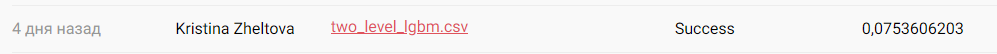

#### Interpretation

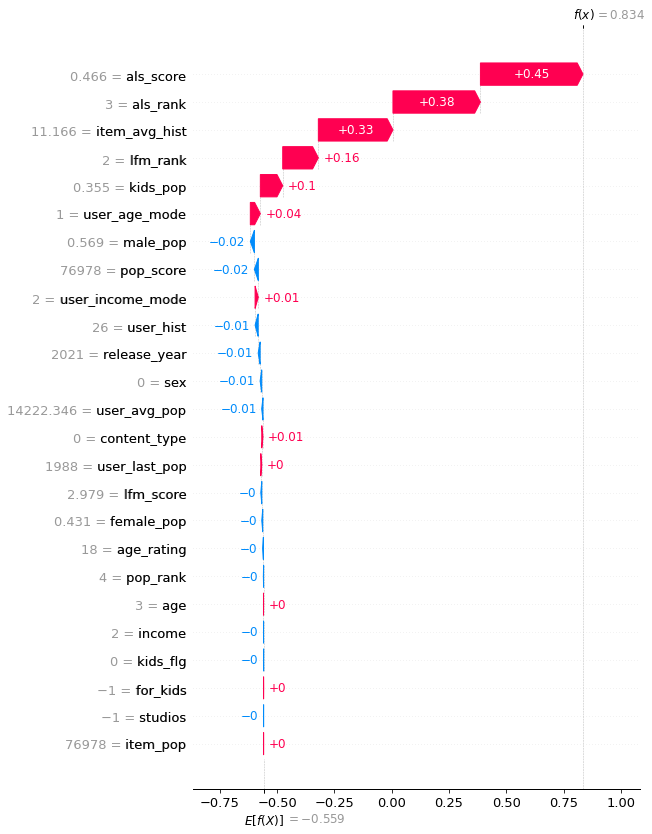

In [ ]:
explainer = shap.Explainer(listwise_model)
shap_values = explainer(ranker_test[cols].iloc[:10_000])

shap.plots.waterfall(shap_values[0], max_display=len(cols))

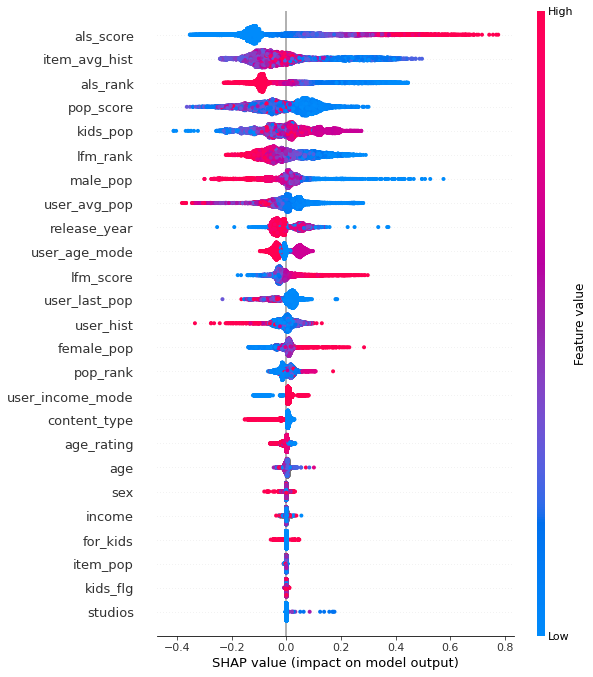

In [ ]:
shap.plots.beeswarm(shap_values, max_display=len(cols))

In [ ]:
(
    avg_user_metric(
        y_true=np.array(ranker_test['target']),  # target_ranker
        y_pred=np.array(ranker_test['listwise_score']),
        user_ids=np.array(ranker_test['user_id']),
        metric_function=roc_auc_score,
    ),
    avg_user_metric(
        y_true=np.array(ranker_test['target']),
        y_pred=np.array(ranker_test['listwise_hybrid_score']),
        user_ids=np.array(ranker_test['user_id']),
        metric_function=roc_auc_score,
    ),
)

(0.8287792220205714, 0.8287792220205714)